In [1]:
import os, sys
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import numpy as np
import qutip as qt
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm

from netket.optimizer import (
    identity_preconditioner,
    PreconditionerT,
)

import jax
import flax
import netket as nk
import netket.nn as nknn
import flax.linen as nn
import optax
from netket.operator import LocalOperator

import copy
import time
from functools import partial

from scipy.linalg import eig, inv

import netket_pro as nkp
import netket_pro.jumps as nkj

from netket.operator.spin import sigmax,sigmay,sigmaz,sigmam,sigmap
from netket.vqs import MCState, FullSumState

In [2]:
def overlap(s1, s2):
    return s1.conj().T @ s2

def fidelity(s1, s2):
    F = overlap(s1, s2) * overlap(s2, s1) / overlap(s1, s1) / overlap(s2, s2)
    return jnp.abs(F.item())

def FS(s1, s2):
    return np.arccos(np.sqrt(fidelity(s1, s2)))

def l2(x,y):
    return np.sqrt(np.sum(np.abs(x - y)**2))

def max_norm1(A):
    return np.max(np.sum(np.abs(A), axis=0))

In [3]:
def pade_optimizer_setup(optimizer, n_iter, target_infidelity=1e-12, SR_maxiter=0, SR_diag_shift=1e-3, cv_coeff=-0.5):
    if SR_maxiter > 0:
        preconditioner = nk.optimizer.SR(solver=partial(jax.scipy.sparse.linalg.cg, maxiter=SR_maxiter), diag_shift=SR_diag_shift, holomorphic=True)
    else:
        preconditioner = nk.optimizer.identity_preconditioner
    
    def pade_optimizer(psi, phi, H, dt, B_den, B_num):
        logger = nk.logging.RuntimeLog()
        te = nkp.driver.MidpointInfidelityOptimizer(
            phi,
            optimizer,
            variational_state=psi,
            H=H,
            dt=dt,
            B_den=B_den,
            B_num=B_num,
            cv_coeff=cv_coeff,
            preconditioner=preconditioner,
        )
        te.run(n_iter=n_iter, out=logger, show_progress=False, target_infidelity=target_infidelity)
        phi.variables = psi.variables
        return logger.data
    
    return pade_optimizer


def solve_variational_evolution(variational_state, H, dt, tf, integration_algorithm, optimizer, n_iter, target_infidelity=1e-12, SR_maxiter=0, SR_diag_shift=1e-3, cv_coeff=-0.5):
    exp_x = pade_optimizer_setup(optimizer, n_iter, target_infidelity=target_infidelity, SR_maxiter=SR_maxiter, SR_diag_shift=SR_diag_shift, cv_coeff=cv_coeff)
    step_function = integration_algorithm(dt, H, exp_x)
    return variational_integrator(variational_state, tf, dt, step_function)
    

def variational_integrator(variational_state, tf, dt, _step):
    psi = variational_state
    phi = copy.copy(psi)
        
    out_dict = {"states": [], "times": [], "infidelity_mean": []}
    
    for t in tqdm(np.arange(0, tf, dt)):
        out_dict["states"].append(copy.copy(psi.to_array()))
        out_dict["times"].append(t)
        
        infidelity_mean, infidelity_var = _step(psi, phi)
        out_dict["infidelity_mean"].append(infidelity_mean)
             
    out_dict["times"] = jnp.array(out_dict["times"])
    
    return out_dict

In [4]:
def step_SplittedPade_O2(dt, H, exp_x):
    A1 = ( +1/2 ) * dt
    A2 = ( +1/2 ) * dt
    B1 = ( -1/2 )
    B2 = ( +1/2 )
    
    Hd,Ho = nkj.operations.split_hamiltonian(H)
    exp_z = nkj.operations.get_apply_exp_diagH(Hd)

    def step_function(psi, phi):
        exp_z(psi, scale=A1)
        phi.variables = psi.variables
        
        logger_data = exp_x(psi, phi, Ho, dt, B1, B2)
        phi.variables = psi.variables
        
        exp_z(psi, scale=A2)
        phi.variables = psi.variables

        infidelity_mean = jnp.abs(logger_data["Infidelity"]["Mean"])
        infidelity_var = logger_data["Infidelity"]["Variance"]
        return infidelity_mean, infidelity_var
        
    return step_function


def step_SplittedPade_O3(dt, H, exp_x):
    a  = 1/4
    b  = np.sqrt(3)/12
    
    A1 = ( +a -1j*b ) * dt
    A2 = ( 1/2 ) * dt
    A3 = ( +a +1j*b ) * dt
    
    B1 = ( -a +1j*b )
    B2 = ( +a -1j*b )
    B3 = ( -a -1j*b )
    B4 = ( +a +1j*b )
    
    Hd,Ho = nkj.operations.split_hamiltonian(H)
    exp_z = nkj.operations.get_apply_exp_diagH(Hd)

    def step_function(psi, phi):
        exp_z(psi, scale=A3)
        phi.variables = psi.variables
        
        logger_data_1 = exp_x(psi, phi, Ho, dt, B3, B4)
        phi.variables = psi.variables
        
        exp_z(psi, scale=A2)
        phi.variables = psi.variables
        
        logger_data_2 = exp_x(psi, phi, Ho, dt, B1, B2)
        phi.variables = psi.variables
        
        exp_z(psi, scale=A1)
        phi.variables = psi.variables
        
        infidelity_mean = [jnp.abs(logger_data_1["Infidelity"]["Mean"]), jnp.abs(logger_data_2["Infidelity"]["Mean"])]
        infidelity_var  = [logger_data_1["Infidelity"]["Variance"], logger_data_2["Infidelity"]["Variance"]]
        return infidelity_mean, infidelity_var
        
    return step_function


def step_Pade_O2(dt, H, exp_x):
    B1 = ( -1/2 )
    B2 = ( +1/2 )    

    def step_function(psi, phi):
        logger_data = exp_x(psi, phi, H, dt, B1, B2)
        phi.variables = psi.variables
        
        infidelity_mean = jnp.abs(logger_data["Infidelity"]["Mean"])
        infidelity_var  = logger_data["Infidelity"]["Variance"]
        return infidelity_mean, infidelity_var
        
    return step_function


def step_Pade_O4(dt, H, exp_x):
    a  = 1/4
    b  = np.sqrt(3)/12
    
    B1 = ( -a -1j * b )
    B2 = ( +a -1j * b )
    B3 = ( -a +1j * b )
    B4 = ( +a +1j * b )

    def step_function(psi, phi):
        logger_data_1 = exp_x(psi, phi, H, dt, B3, B4)
        phi.variables = psi.variables
        
        logger_data_2 = exp_x(psi, phi, H, dt, B1, B2)
        phi.variables = psi.variables        
        
        infidelity_mean = [jnp.abs(logger_data_1["Infidelity"]["Mean"]), jnp.abs(logger_data_2["Infidelity"]["Mean"])]
        infidelity_var  = [logger_data_1["Infidelity"]["Variance"], logger_data_2["Infidelity"]["Variance"]]
        return infidelity_mean, infidelity_var
        
    return step_function

In [5]:
# INTEGRATOR
def integrator(psi0, dt, tf, f_apply,):
    psi = copy.copy(psi0)
    t_list = []
    psi_list = []
    
    _step = f_apply(dt)
        
    for t in tqdm(np.arange(0, tf, dt)):
        psi_list.append(psi.full())
        t_list.append(t)
        
        psi = _step(psi)
        psi = psi/np.linalg.norm(psi)
        
    t_list = np.array(t_list)
    return t_list, psi_list

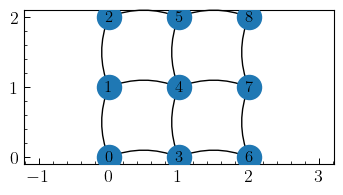

In [6]:
# Define geometry
Lx, Ly = 3, 3
g  = nk.graph.Grid((Lx, Ly), pbc=False)
g.draw(figsize=(4,2))
N  = g.n_nodes
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

γ = 0.
h = 1.
J = 1.

H = sum([J * sigmaz(hi, i) * sigmaz(hi, j) for i,j in g.edges()]) 
H+= sum([h * sigmax(hi, i) for i in g.nodes()])
c_ops = [np.sqrt(γ) * sigmam(hi,i) for i in g.nodes()]
e_ops = [sum([sigmaz(hi,i) for i in g.nodes()])/N, sum([sigmax(hi,i) for i in g.nodes()])/N] + [sigmaz(hi,i) for i in g.nodes()]

In [7]:
dt = 0.05
tf = 1.

In [8]:
alpha = 9
model = nkj.networks.RBM(alpha=alpha, param_dtype=complex, use_visible_bias=False)
model = nkj.networks.ExtendedNetwork(model, param_dtype=complex, kernel_two_body_init=nn.initializers.normal(), delta_dw_init=nn.initializers.normal(), delta_up_init=nn.initializers.normal())
vgs = nk.vqs.FullSumState(hi, model)

# H0 = sum([sigmax(hi, i) for i in g.nodes()])
# print("Ground state energy: ", H0.to_qobj().groundstate()[0])

# lr = 0.01
# n_iter = 500
# optimizer = optax.adabelief(learning_rate=lr)
# gs_driver = nk.driver.VMC(H0, optimizer, variational_state=vgs)
# gs_driver.run(n_iter, out=nk.logging.RuntimeLog(), show_progress=True);

with open("initial_state_3x3_alpha=%d.mpack"%alpha, 'rb') as file:
  vgs = flax.serialization.from_bytes(vgs, file.read())

In [9]:
H_qo  = H.to_qobj()
Hd_qo = qt.Qobj(np.diag(H_qo.diag()) , dims=H_qo.dims)
Ho_qo = H_qo - Hd_qo 
psi0_qo = vgs.to_qobj().unit()

λ, R = eig(H_qo.full())
L = inv(R)

I = qt.qeye(2**N).full()

def exact(dt):
    T = R @ np.diag(np.exp(-1j * λ * dt)) @ L
    T = qt.Qobj( T , dims=H_qo.dims )
    return lambda psi: T * psi

def symplectic_pade_2(dt):
    hz = -1j * dt * Hd_qo.diag()
    D = np.diag(np.exp(1/2 * hz))
    D = qt.Qobj( D , dims=H_qo.dims ) 

    hx = -1j * dt * Ho_qo.full()
    O_n = I + 1/2 * hx
    O_d = I - 1/2 * hx
    O = qt.Qobj( inv(O_d) @ O_n , dims=H_qo.dims )
    T = D * O * D
    return lambda psi: T * psi

def pade_2(dt):
    h = -1j * dt * H_qo.full()
    O_n = I + 1/2 * h
    O_d = I - 1/2 * h
    T = qt.Qobj( inv(O_d) @ O_n , dims=H_qo.dims )
    return lambda psi: T * psi


def symplectic_pade_3(dt):
    z = -1j * Hd_qo.diag()
    x = -1j * Ho_qo.full()

    A1 = +0.25 - 0.144338 * 1j 
    A2 = +0.5
    A3 = +0.25 + 0.144338 * 1j
    B1 = -0.25 + 0.144338 * 1j 
    B2 = +0.25 - 0.144338 * 1j
    B3 = -0.25 - 0.144338 * 1j
    B4 = +0.25 + 0.144338 * 1j
    
    D1 = np.diag(np.exp(A1 * z * dt))
    D2 = np.diag(np.exp(A2 * z * dt))
    D3 = np.diag(np.exp(A3 * z * dt))
    
    H1 = I+B1*x*dt
    H2 = I+B2*x*dt
    N1 = inv(H1) @ H2
    
    H1 = I+B3*x*dt
    H2 = I+B4*x*dt
    N2 = inv(H1) @ H2
    
    T = D1 @ N1 @ D2 @ N2 @ D3
    T = qt.Qobj( T , dims=H_qo.dims )
    return lambda psi: T * psi


def pade_4(dt):
    h = -1j * dt * H_qo.full()
    
    B1 = -0.25 - 1j * 0.144338  # -0.25 - 1j * 0.144338
    B2 = +0.25 - 1j * 0.144338  # +0.25 + 1j * 0.144338
    B3 = -0.25 + 1j * 0.144338  # -0.25 + 1j * 0.144338 
    B4 = +0.25 + 1j * 0.144338  # +0.25 - 1j * 0.144338 

    H1 = I + B1 * h
    H2 = I + B2 * h
    H3 = I + B3 * h
    H4 = I + B4 * h
    
    T = inv(H1) @ H2 @ inv(H3) @ H4
    T = qt.Qobj( T , dims=H_qo.dims )
    return lambda psi: T * psi

In [10]:
times_full, states_full = integrator(psi0_qo, dt, tf, symplectic_pade_3,)
_, states_exact = integrator(psi0_qo, dt, tf, exact,)

100%|██████████| 20/20 [00:00<00:00, 800.38it/s]


In [11]:
psi = nk.vqs.FullSumState(hi, model) 
psi.variables = vgs.variables

lr = 1e-3
optimizer = optax.adabelief(learning_rate=lr,)
n_iter = 500
SR_maxiter = 30
SR_diag_shift = 1e-3
target_infidelity = 1e-15

obs_dict = solve_variational_evolution(psi, H, dt, tf, step_SplittedPade_O3, optimizer, n_iter, target_infidelity=target_infidelity, SR_maxiter=SR_maxiter, SR_diag_shift=SR_diag_shift,)

100%|██████████| 20/20 [09:13<00:00, 27.67s/it]


In [12]:
states = obs_dict["states"]
times = obs_dict["times"]
opt_infs = obs_dict["infidelity_mean"]
opt_inf_final = [i[0][-1] for i in opt_infs]

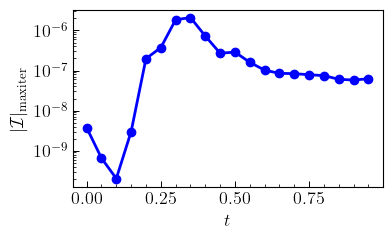

In [13]:
fig,ax = plt.subplots(1,1, figsize=(4.,2.3), gridspec_kw={"wspace":0.4}, sharex=True)
ax.plot(times, opt_inf_final, 'o-')
ax.set_yscale("log")

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$|\mathcal{I}|_{\rm maxiter}$");

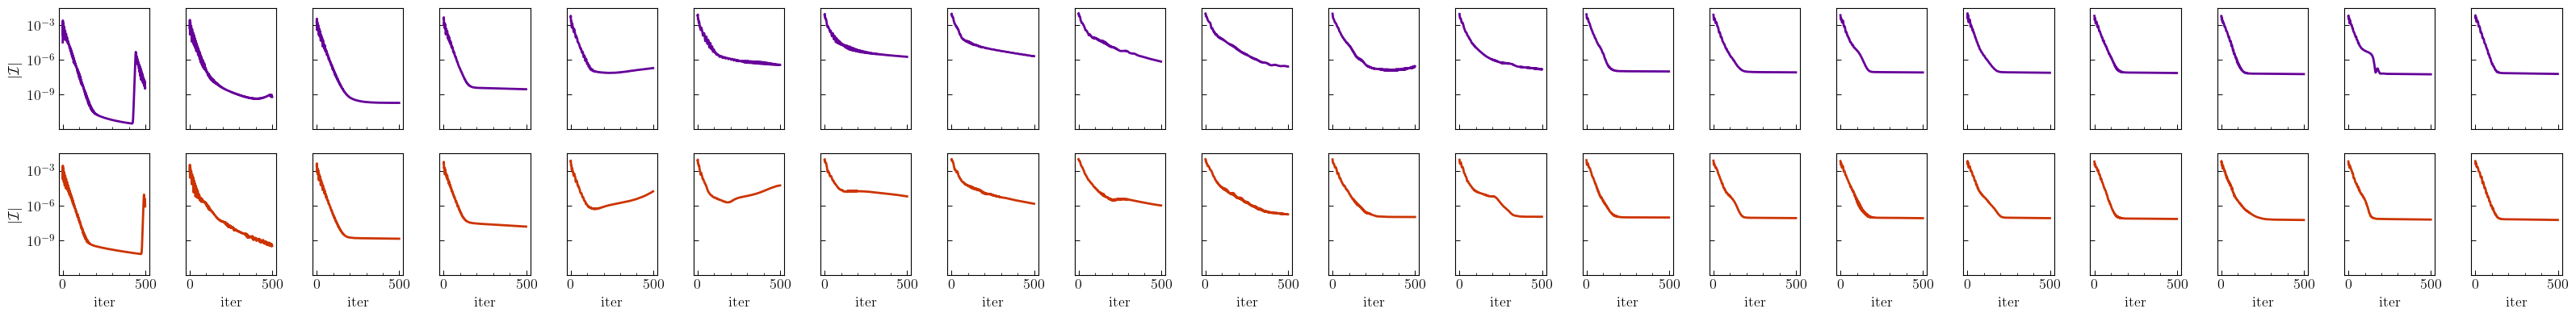

In [58]:
nf = len(times)
fig,ax = plt.subplots(2,nf, figsize=(40.,4.3), gridspec_kw={"wspace":0.4}, sharex=True, sharey=True)

for i in range(0, nf):
    inf_0 = opt_infs[i][0]
    inf_1 = opt_infs[i][1]

    ax[0,i].plot(inf_0, 'C1-')
    ax[1,i].plot(inf_1, 'C3-')
    ax[0,i].set_yscale("log")

    ax[1,i].set_xlabel(r"iter")
ax[0,0].set_ylabel(r"$|\mathcal{I}|$")
ax[1,0].set_ylabel(r"$|\mathcal{I}|$");

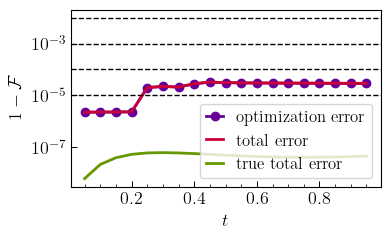

In [17]:
inf_full  = [1. - fidelity(s1,s2) for s1,s2 in zip(states, states_full)]
inf_exact = [1. - fidelity(s1,s2) for s1,s2 in zip(states, states_exact)]
inf_full_exact = [1. - fidelity(s1,s2) for s1,s2 in zip(states_full, states_exact)]

fig,ax = plt.subplots(1,1, figsize=(4.,2.3), gridspec_kw={"wspace":0.4}, sharex=True)
ax.plot(times[1:], inf_full[1:] , "C1o-", label="optimization error")
ax.plot(times[1:], inf_exact[1:], "C2", label="total error")
ax.plot(times[1:], inf_full_exact[1:], "C4", label="true total error")
ax.set_yscale("log")

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$1 - \mathcal{F}$")

ax.legend()
ax.axhline(1e-2, c="k", ls="--", lw=1)
ax.axhline(1e-3, c="k", ls="--", lw=1)
ax.axhline(1e-4, c="k", ls="--", lw=1)
ax.axhline(1e-5, c="k", ls="--", lw=1);